In [ ]:
#Install pySpark
#!pip install pyspark

In [ ]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import storage

#Authenticate User
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# Initialize a GCS client
storage_client = storage.Client()

# Define bucket and file paths
landing_folder_name = 'trusted'
input_file_name = 'tested nypd_mv_collisions'
output_folder_name = 'models'
output_file_name = 'models nypd_mv_collisions'

# Read data from the landing folder file
landing_bucket = storage_client.bucket('my-project-bucket-bc')
landing_blob = landing_bucket.blob(f'{landing_folder_name}/{input_file_name}')
local_file_path = '/tmp/input_file.csv'
landing_blob.download_to_filename(local_file_path)

Authenticated


In [ ]:
df = pd.read_parquet(local_file_path)

In [ ]:
import os

os.environ["HADOOP_CONF_DIR"] = "/usr/local/lib/python3.10/dist-packages/pyspark"

from pyspark.sql import SparkSession

# Initialize SparkSession with additional libraries for GCS support
spark = SparkSession.builder \
    .appName("NYPD Collisions Analysis") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.fs.gs.project.id", "my-project-bucket-bc") \
    .config("spark.hadoop.fs.gs.auth.service.account.enable", "true") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "cis-4130-semester-project-18c39c58bea4.json") \
    .config("spark.hadoop.fs.gs.auth.service.account.json.keyfile", "cis-4130-semester-project-18c39c58bea4.json") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [ ]:
spark_df = spark.createDataFrame(df)

In [ ]:
# Import some modules needed later on
from pyspark.sql.functions import col, isnan, when, count, udf, to_date, year, month, date_format, size, split
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import to_timestamp

# Convert the timestamp column to an actual timestamp data type, and the other format of time
spark_df = spark_df.withColumn('timestamp', to_timestamp(spark_df.timestamp, 'yyyy-MM-dd HH:mm:ss'))
spark_df = spark_df.withColumn("time_year", year("timestamp"))
spark_df = spark_df.withColumn("time_month", month("timestamp"))
spark_df = spark_df.withColumn("time_yearmonth", date_format("timestamp", "yyyy-MM"))
spark_df = spark_df.withColumn("time_dayofweek", date_format("timestamp", "E"))
spark_df = spark_df.withColumn("time_weekend", when(spark_df.time_dayofweek == 'Saturday', 1.0)
                               .when(spark_df.time_dayofweek == 'Sunday', 1.0)
                               .otherwise(0))
spark_df.printSchema()

root
 |-- borough: string (nullable = true)
 |-- contributing_factor_vehicle_1: string (nullable = true)
 |-- contributing_factor_vehicle_2: string (nullable = true)
 |-- contributing_factor_vehicle_3: string (nullable = true)
 |-- contributing_factor_vehicle_4: string (nullable = true)
 |-- contributing_factor_vehicle_5: string (nullable = true)
 |-- cross_street_name: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- number_of_cyclist_injured: long (nullable = true)
 |-- number_of_cyclist_killed: long (nullable = true)
 |-- number_of_motorist_injured: long (nullable = true)
 |-- number_of_motorist_killed: long (nullable = true)
 |-- number_of_pedestrians_injured: long (nullable = true)
 |-- number_of_pedestrians_killed: long (nullable = true)
 |-- number_of_persons_injured: long (nullable = true)
 |-- number_of_persons_killed: long (nullable = true)
 |-- unique_key: long (nullable = true)
 |-- vehicle_type_code1: string (nullable = true)
 |-- vehicle_type_code

In [ ]:
columns_info = [(col_name, col_data_type) for col_name, col_data_type in spark_df.dtypes]
# Determine feature engineering treatments
feature_engineering_treatments = [(col_name, col_data_type, 'Indexer') if str(col_data_type) == 'string' else
                                  (col_name, col_data_type, 'Modeler') if str(col_data_type) in ['int', 'DoubleType'] else
                                  (col_name, col_data_type, 'Scaler') for col_name, col_data_type in columns_info]
# Create a new DataFrame to store the information
feature_info_df = spark.createDataFrame(feature_engineering_treatments, ["Column Name", "Column Type","Feature Engineering Treatment"])

# Show the DataFrame
feature_info_df.show()

# Write the DataFrame to a file on your local desktop
#feature_info_df.write.csv('file:///C:/Users/bella/Downloads/feature_info.csv', header=True, mode='overwrite')

+--------------------+-----------+-----------------------------+
|         Column Name|Column Type|Feature Engineering Treatment|
+--------------------+-----------+-----------------------------+
|             borough|     string|                      Indexer|
|contributing_fact...|     string|                      Indexer|
|contributing_fact...|     string|                      Indexer|
|contributing_fact...|     string|                      Indexer|
|contributing_fact...|     string|                      Indexer|
|contributing_fact...|     string|                      Indexer|
|   cross_street_name|     string|                      Indexer|
|           timestamp|  timestamp|                       Scaler|
|number_of_cyclist...|     bigint|                       Scaler|
|number_of_cyclist...|     bigint|                       Scaler|
|number_of_motoris...|     bigint|                       Scaler|
|number_of_motoris...|     bigint|                       Scaler|
|number_of_pedestr...|   

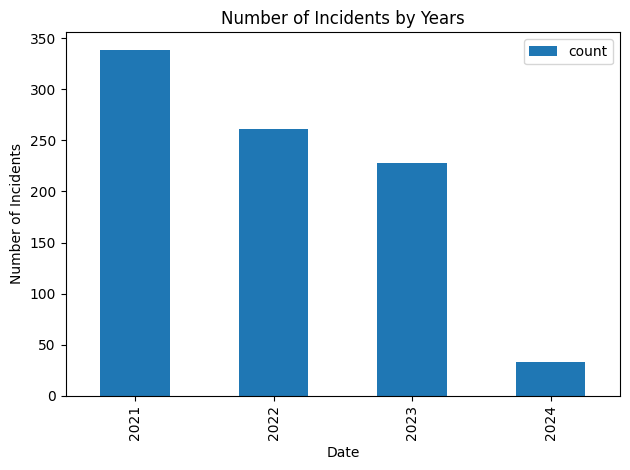

In [ ]:
# Use groupby to get a count by date. Then convert to pandas dataframe
summary_spark = spark_df.where(col("time_year") > 2020).groupby("time_year").count().sort("time_year")
df = summary_spark.toPandas()

# df = sdf.where(col("order_year") > 2020).groupby("order_date") \
#           .count().sort("order_date").toPandas()

# Using Pandas built-in plotting functions
# Create a bar plot using the columns order_date and count
myplot = df.plot.bar('time_year','count')
# Set the x-axis and y-axis labels
myplot.set(xlabel='Date', ylabel='Number of Incidents')
# Set the title
myplot.set(title='Number of Incidents by Years')
myplot.figure.set_tight_layout('tight')
# Save the plot as a PNG file
#myplot.get_figure().savefig("order_count_by_date.png")

In [ ]:
# Save the plot to Google Cloud Storage
import io
from google.cloud import storage

# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the img_data buffer
myplot.get_figure().savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket on Google Cloud Storage (change this to match the name of your bucket)
bucket = storage_client.get_bucket('my-project-bucket-bc')

folder_path = 'models'
file_name = "Number of Incidents by Years.png"
# Create a blob to hold the data. Give it a file name with the folder path included
blob = bucket.blob(f'{folder_path}/{file_name}')

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)

Text(0.5, 1.0, 'Frequency by Borough')

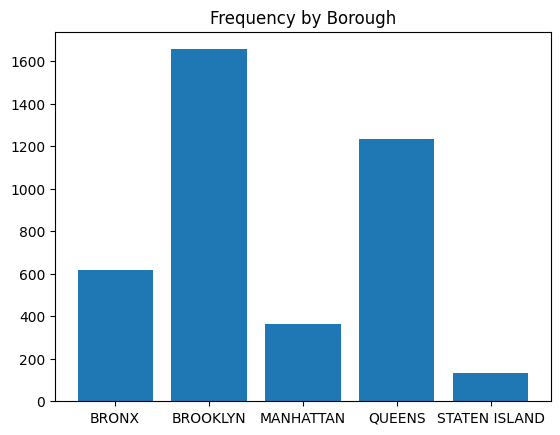

In [ ]:
## Show frequency of the 'Borough' column
sparks_df_BO = spark_df.groupby('borough').count().sort('borough').toPandas()
# Set up a Matplotlib figure
fig = plt.figure(facecolor='white')
# Bar Plot of borough and count
plt.bar(sparks_df_BO['borough'],sparks_df_BO['count'] )
# Add a title
plt.title("Frequency by Borough")
# Save the figure to a local directory
#plt.savefig("frequency_food_ordered.png")

In [ ]:
# Create a buffer to hold the figure
img_data = io.BytesIO()
# Write the figure to the img_data buffer
fig.get_figure().savefig(img_data, format='png', bbox_inches='tight')
# Rewind the pointer to the start of the data
img_data.seek(0)

# Connect to Google Cloud Storage
storage_client = storage.Client()
# Point to the bucket on Google Cloud Storage (change this to match the name of your bucket)
bucket = storage_client.get_bucket('my-project-bucket-bc')

folder_path = 'models'
file_name = "Frequency by Borough.png"
# Create a blob to hold the data. Give it a file name with the folder path included
blob = bucket.blob(f'{folder_path}/{file_name}')

# Upload the img_data contents to the blob
blob.upload_from_file(img_data)